In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt

# Heterogenous treatment effects

### We will continue with the online discount example by Matteo Courthoud. That is, let's suppose we work in the analytics department of an online shop interested in understanding wether offering discounts to new customers increases their expenditure. In particular, we would like to know if offering discounts is more effective for some customers with respect to others, since we would prefer not to give discounts to customers that would spend anyways. Moreover, it could also be that spamming customers with pop-ups could deter them from buying, having the opposite effect.

### To understand whether and how much the discounts are effective we run an A/B test: whenever a new user visits our online shop, we randomly decide whether to offer them the discount or not. After 100 000 visits, we have collected the following dataset with relevant information beside the discount status (our treatment).

In [2]:
df = pd.read_csv('online_discounts.csv') 
df.head()
# tratamiento es discount y el output es spend

Unnamed: 0       time   device   browser  region  discount      spend
0           0  10.779006   mobile      edge       9         0   0.455164
1           1   0.568973  desktop   firefox       9         0  11.036871
2           2   3.743871   mobile    safari       7         0   1.811193
3           3  13.373436  desktop     other       5         0  31.904944
4           4   0.708575   mobile  explorer       2         1  15.419862

### Since the treatment was randomly assigned, we can use a simple difference-in-means estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the discount, therefore we can causally attribute any difference in spend to the discount

### Estimador de diferencia en medias --> coeficiente de regresion correspondiente a una regresion con un intercepto y la variable de tratamiento (coeficiente de la var de tratamiento)

In [3]:
import statsmodels.formula.api as smf
smf.ols('spend ~ discount', df).fit().summary().tables[1]
# esta forma permite hacer regresion OLS con los regresores a la derecha, lo que no suele ser disponible en python

<class 'statsmodels.iolib.table.SimpleTable'>

### The discount seems to be effective: on average the spend in the treatment group increases by 1.75$. But are all customers equally affected? 

### To answer this question, we would like to estimate heterogeneous treatment effects, possibly at the individual level.



# Conditional Average Treatment Effects (CATE)

### There are many possible ways to estimate heterogenous treatment effects. The most common is to split the population in groups based on some observable characteristic, which in our case could be the device, the browser or the geographical region. Once you have decided which variable to split your data on, you can simply interact the treatment variable (discount) with the dimension of treatment heterogeneity. Let’s take device for example.

In [4]:
smf.ols('spend ~ discount * device', df).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### The interpretation of these results follows the same fashion as the previous ones: the effect of the discount on customers' spend is 1.08$, but it increases by a further 1.32$ if the customer is accessing the website from a mobile device.

### Splitting is easy for categorical variables, but for a continuous variable like time it is not intuitive where to split. Every hour? And which dimension is more informative? It would be temping to try all possible splits, but the more we split the data, the more it is likely that we find spurious results (i.e. we overfit, in machine learning lingo). It would be great if we could let the data speak and select the minimum and most informative splits.

### Moreover, the splitting problem must minimize the following objective function:

\begin{equation*}
\sum_{i}\left[\left(\tau_i-\hat{\tau} \left(X_i\right)\right)^2\right]
\end{equation*}


### La anterior ecuación es unfeasible, imposible de implementar ya que el efecto causal no es observable. Ahí Athey e Imbens (2016) sugieren la transformación del outcome tal que se pueda diferenciar del efecto de tratamiento y control. Este es un estimador insesgado y consistente del verdadero efecto causal. $\hat{Y}$ es la predicción del efecto causal

### Important issue: the objective function is unfeasible. A way out to this problem is to use Athey and Imbens (2016) outcome transformation

\begin{equation*}
Y_i^* =
\begin{cases}
 Y_i/p & W_i = 1 \\
-Y_i/(1-p) & W_i = 0
\end{cases}

\end{equation*}


### So, performing any predictive method to estimate $\hat{Y}_i^*$ will end up being th predicte CATE because 

\begin{equation*}

\mathbb{E}\left[Y_i^*|X_i=x\right] = \tau(x)

\end{equation*}

### That is, with this transformed variable we have transformed our treatment effect prediction problem to a plain outcome prediction problem. 

### A natural question arises from the definition transformed variable: what is $p$? $p$ is non other than the propensity score. That is, the probability of the individual of being treated. In an experimental study (like this one), we know this value beforehand. In observational studies, we would calculate it using a probit or logit regression. Eventhough we have programmed the discount to be given completely random (so we know $p=0.5$), it is advisable to estimate the propensity score to account for sample uncertainty.

In [5]:
df['region'].value_counts()

region
3    10116
8    10105
0    10089
6    10021
1    10009
9     9987
4     9970
5     9967
7     9938
2     9798
Name: count, dtype: int64

In [6]:
# Dropeamos variables categoricas para generar dummies y evitar multicolinealidad
df['region']= df['region'].astype(str)

df_dummies = pd.get_dummies(df[['device','browser','region']], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
X = ['time'] + list(df_dummies.columns)

In [7]:
X

['time',
 'device_mobile',
 'browser_chrome',
 'browser_edge',
 'browser_explorer',
 'browser_firefox',
 'browser_other',
 'browser_safari',
 'region_1',
 'region_2',
 'region_3',
 'region_4',
 'region_5',
 'region_6',
 'region_7',
 'region_8',
 'region_9']

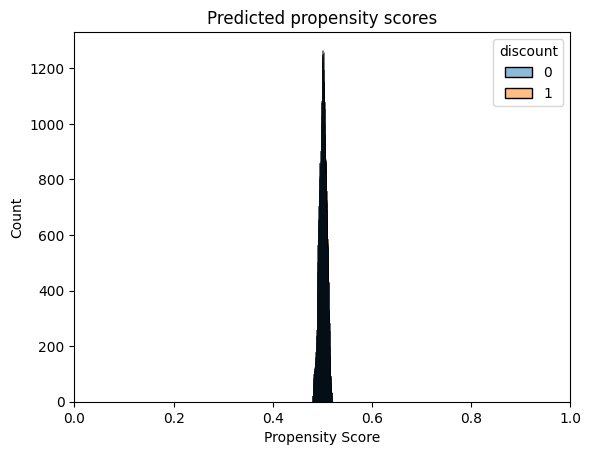

In [8]:
# linear_model alude a que el predictor es lineal, no que es una regresion lineal
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# calculamos el propensity score
df['pscore'] = LogisticRegression().fit(df[X], df['discount']).predict_proba(df[X])[:,1]

# df(X) -> subconjunto del data frame
# df['discount'] -> variable de respuesta va a seer el descuento de tratamiento
# calcula los propensity scores para cada observación en el conjunto de datos. Los propensity scores son probabilidades estimadas de que una observación reciba un 
# tratamiento dados los valores de las variables predictoras.

sns.histplot(data=df, x='pscore', hue='discount').set(
    title='Predicted propensity scores', xlim=[0,1], xlabel='Propensity Score')
plt.show()

### El pscore sale 0.5 porque este es un estudio experimental (como el A/B testing) donde el tratamiento es experimentado de manera aleatoria

### As expected, the histogram of the propensity score reveals that the treatment is completely random. Now, with the estimated propensity score of each individual we can calculate $Y_i^*$

In [9]:
# Aiuste del gasto dependiendo de la probabilidad de que ocurra un descueto
df['y_star'] = df['spend'] / (df['discount'] * df['pscore'] - (1-df['discount']) * (1-df['pscore']))

### As we said before, the idea is to use $Y_i^*$ as the target of a prediction problem, since the expected value is exactly the individual treatment effect. Let’s check its average in the data.

In [10]:
df['y_star'].mean()

1.757432826474874

### Es decir, al crear el $Y$* se toma en cuenta la probabilidad de que se de un descuento, y en cierta medida, es el efecto causal del descuento en el gasto considerando la probabilidad de que haya descuento como la probabilidad de que no lo haya, pero dado de que ambas probabilidades son en promedio iguales, se parece mucho al efecto causal del descuento en el gasto estimado mediante OLS.

### Although $Y_i^*$ is an unbiased estimator for the individual treatment effect, it has a very high variance

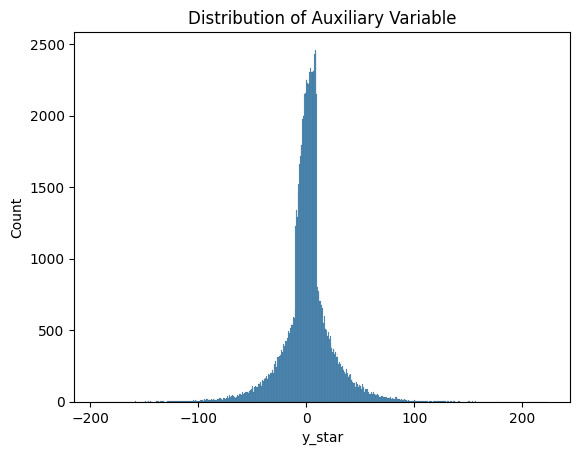

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(df['y_star'], ax=ax).set(title='Distribution of Auxiliary Variable')
plt.show()

### Now, with all the arguments given above, we can build a regression tree with the transformed outcome to calculate the predicted CATE

In [12]:
df[X]

time  device_mobile  browser_chrome  browser_edge  \
0      10.779006           True           False          True   
1       0.568973          False           False         False   
2       3.743871           True           False         False   
3      13.373436          False           False         False   
4       0.708575           True           False         False   
...          ...            ...             ...           ...   
99995  14.224321          False           False         False   
99996  15.804262          False           False         False   
99997   2.364713          False           False         False   
99998   3.723502          False           False          True   
99999  10.108936           True            True         False   

       browser_explorer  browser_firefox  browser_other  browser_safari  \
0                 False            False          False           False   
1                 False             True          False           False   
2                 False            False          False            True   
3                 False            False           True           False   
4                  True            False          False           False   
...                 ...              ...            ...             ...   
99995             False             True          False           False   
99996             False            False           True           False   
99997             False            False          False            True   
99998             False            False          False           False   
99999             False            False          False           False   

       region_1  region_2  region_3  region_4  region_5  region_6  region_7  \
0         False     False     False     False     False     False     False   
1         False     False     False     False     False     False     False   
2         False     False     False     False     False     False      True   
3         False     False     False     False      True     False     False   
4         False      True     False     False     False     False     False   
...         ...       ...       ...       ...       ...       ...       ...   
99995     False     False     False     False     False     False     False   
99996     False     False     False     False      True     False     False   
99997     False     False     False     False     False     False     False   
99998     False     False     False      True     False     False     False   
99999     False      True     False     False     False     False     False   

       region_8  region_9  
0         False      True  
1         False      True  
2         False     False  
3         False     False  
4         False     False  
...         ...       ...  
99995     False      True  
99996     False     False  
99997     False      True  
99998     False     False  
99999     False     False  

[100000 rows x 17 columns]

In [13]:
from sklearn.tree import DecisionTreeRegressor

# Utilizamos arbol con las covariables dummy y luego el estimador del efecto causal Y*
tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star']) # aqui el paramámetro de pruning se pone en 2
df['y_hat'] = tree.predict(df[X])

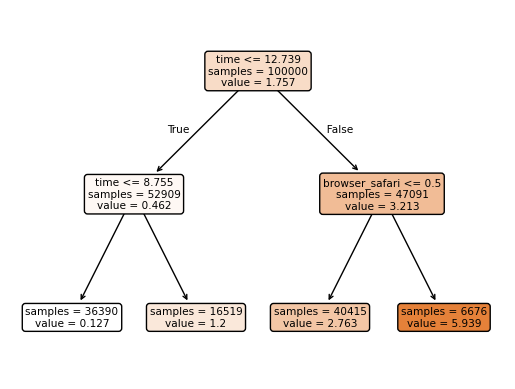

In [14]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True, feature_names=X, impurity=False, rounded=True)
plt.show()

### Se lee, si el descuento se da antes del medio día pasan dos cosas: si se conecta antes de las 8, el efecto causal del descuento sobre el gasto es 0.127; si se conecta entre las 8 y las 12 el efecto es de 1.2. Por otro lado, si los individuos se conectan despues de las 12 pasan dos cosas: si no se concecta desde safari (como safari es dicotomica, cuando es menor a 0.5 significa que es cero, por lo tanto no se conecta mediante safari) el efecto causal es 2.763; si se conecta mediante safaria el efecto causal es 5.939.

### Some caveats should be given about the results of this tree. First, the CATE estimates will be unbiased only if, within each leave, we have the same number of treated and control units. And second, we have used the same data to generate and evaluate the tree, which generates overfitting.

# Generating Splits

### Last but not least, how should the tree be generated? The default rule to generate splits minimizing the sum of squared errors metric, so there is no restriction on the minimum number of observations per leaf. Other commonly used rules include, mean absolute error, Gini’s impurity, and Shannon’s information. Which one performs better depends on the specific application, but the general objective is always prediction accuracy, broadly defined.

### In that regard, Athey and Imbens (2016) use a modified version of the Mean Squared Error (MSE) as splitting criterion, named the Expanded Mean Squared Error (EMSE)

\begin{equation*}

EMSE = \mathbb{E}\left[\left(Y_i-\hat{\mu}(X_i)\right)^2-Y_i^2\right]

\end{equation*}

### Luckily, there are multiple libraries where the so-called causal trees are implemented. We import CausalForestDML from Microsoft’s EconML library, one of the best libraries for causal inference

In [15]:
pip install econml

Note: you may need to restart the kernel to use updated packages.


In [16]:
from econml.dml import CausalForestDML
import numpy as np 
np.random.seed(0)
# con subforest_size se convierte en un único arbol causal
# aqui no es necesario transformar la variable a Y*
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df['spend'], X=df[X], T=df['discount'])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


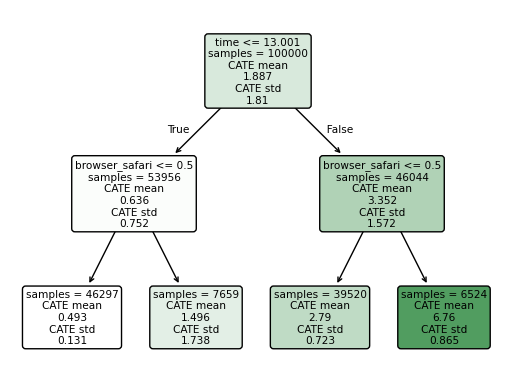

In [17]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X)
plt.show()